In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Accuracy

from sklearn.metrics import confusion_matrix, classification_report

In [5]:
#Define information about training images 

training_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05
)
# Imported training images with specific requirements
training_iterator = training_generator.flow_from_directory(
  'Covid19-dataset/train',
  class_mode = "categorical",
  color_mode = 'grayscale',
  target_size = (256,256),
  batch_size = 32,
  shuffle=True
)

# Define information about validation images 
validation_generator = ImageDataGenerator(rescale=1./255)
# Imported training images with specific requirements
validation_iterator = validation_generator.flow_from_directory(
  'Covid19-dataset/test',
  class_mode = "categorical",
  color_mode = 'grayscale',
  target_size = (256,256),
  batch_size = 32,
  shuffle=True
)


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


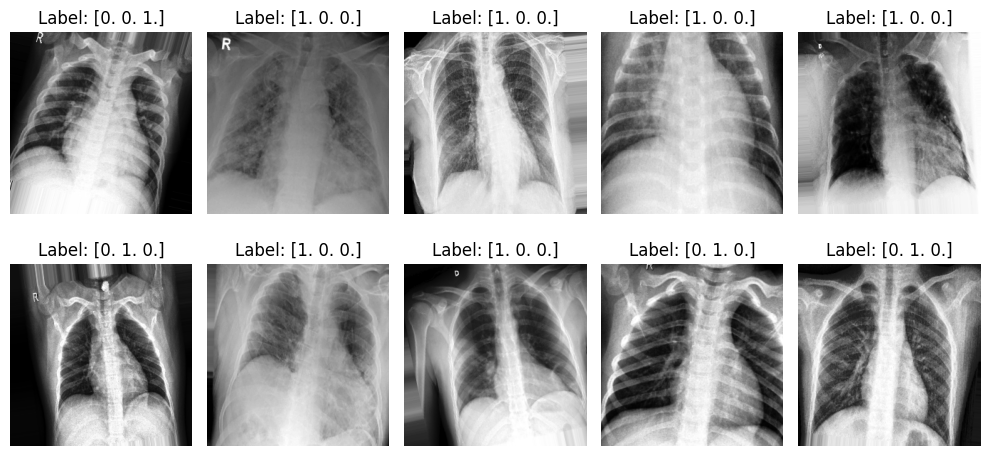

In [6]:
# Get the first batch of images and labels from the iterator
images, labels = training_iterator.next()

# Create a figure with 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Display the first 10 images in the batch
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def plotting_accuracy(history):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid()
    ax1.legend(['train', 'validation'], loc='upper left')

    # used to keep plots from overlapping
    fig.tight_layout()
    
def plotting_loss(history):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend(['train', 'validation'], loc='upper left')

    # used to keep plots from overlapping
    fig.tight_layout()

def evaluation_metrics(model_type):

    y_pred = model_type.predict(validation_iterator)
    y_pred = np.argmax(y_pred, axis=1)
    true_classes = validation_iterator.classes
    # class_labels = list(validation_iterator.class_indices.keys())
    
    cm = confusion_matrix(true_classes, y_pred)
    print('Confusion Matrix')
    print(cm)
    print('Classification Report')
    print(classification_report(true_classes, y_pred))

In [8]:
# plotting categorical and validation accuracy over epochs
es = EarlyStopping(monitor='categorical_accuracy', mode='min', verbose=1, patience=10)

In [9]:
# Create Model
def design_model_1(training_data):

    model_1 = Sequential()
    # Input Layer
    model_1.add(Input(shape=(256,256,1)))
    # Flatten Layer
    model_1.add(Flatten())
    # Output Layer
    model_1.add(Dense(3, activation='softmax'))
    
    print("\nCompiling model...")
    model_1.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(),AUC()],)
    # Summary report 
    model_1.summary()
    
    return model_1
    
model_1 = design_model_1(training_iterator)


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 3)                 196611    
                                                                 
Total params: 196,611
Trainable params: 196,611
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training the model
history_1 = model_1.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

Epoch 1/20
8/8 [==============================] - 3s 323ms/step - loss: 15.0346 - categorical_accuracy: 0.4900 - auc: 0.6334 - val_loss: 19.5525 - val_categorical_accuracy: 0.5758 - val_auc: 0.6847
Epoch 2/20
8/8 [==============================] - 1s 188ms/step - loss: 9.4446 - categorical_accuracy: 0.5657 - auc: 0.7112 - val_loss: 9.6574 - val_categorical_accuracy: 0.5303 - val_auc: 0.6449
Epoch 3/20
8/8 [==============================] - 2s 210ms/step - loss: 4.3629 - categorical_accuracy: 0.6813 - auc: 0.8106 - val_loss: 3.7555 - val_categorical_accuracy: 0.7121 - val_auc: 0.8115
Epoch 4/20
8/8 [==============================] - 2s 198ms/step - loss: 3.0710 - categorical_accuracy: 0.7251 - auc: 0.8358 - val_loss: 5.5206 - val_categorical_accuracy: 0.6212 - val_auc: 0.7367
Epoch 5/20
8/8 [==============================] - 2s 191ms/step - loss: 2.5008 - categorical_accuracy: 0.7888 - auc: 0.8746 - val_loss: 2.7314 - val_categorical_accuracy: 0.6818 - val_auc: 0.8182
Epoch 6/20
8/8 [==

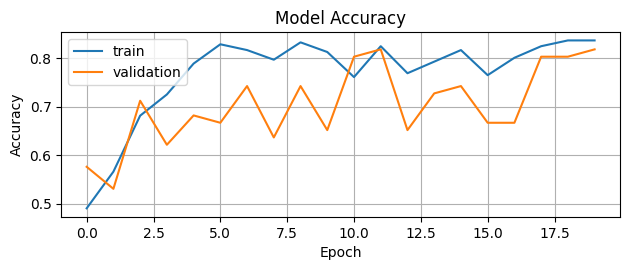

In [11]:
plotting_accuracy(history_1)

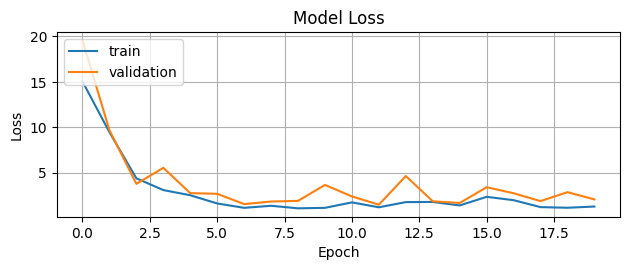

In [12]:
plotting_loss(history_1)

In [16]:
evaluation_metrics(model_1)

3/3 [==============================] - 0s 36ms/step
Confusion Matrix
[[ 9 13  4]
 [ 9  5  6]
 [ 5 12  3]]
Classification Report
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        26
           1       0.17      0.25      0.20        20
           2       0.23      0.15      0.18        20

    accuracy                           0.26        66
   macro avg       0.26      0.25      0.25        66
weighted avg       0.27      0.26      0.26        66



In [19]:
def design_model_2(training_data):
    # sequential model
    model_2 = Sequential()
    # add input layer with grayscale image shape
    model_2.add(Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model_2.add(Conv2D(5, 5, strides=3, activation="relu")) 
    model_2.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model_2.add(Dropout(0.1))
    model_2.add(Conv2D(3, 3, strides=1, activation="relu")) 
    model_2.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model_2.add(Dropout(0.2))

    model_2.add(Flatten())
    # output layer with softmax activation function
    model_2.add(Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model_2.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(),AUC()],)
    # summarize model
    model_2.summary()
    return model_2

# use model function
model_2 = design_model_2(training_iterator)


Compiling model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 5)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 42, 42, 5)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 3)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None

In [20]:
# training the model
history_2 = model_2.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

Epoch 1/20
8/8 [==============================] - 3s 249ms/step - loss: 1.1093 - categorical_accuracy: 0.4781 - auc_1: 0.6030 - val_loss: 1.0253 - val_categorical_accuracy: 0.5606 - val_auc_1: 0.7267
Epoch 2/20
8/8 [==============================] - 2s 217ms/step - loss: 0.9817 - categorical_accuracy: 0.5458 - auc_1: 0.7288 - val_loss: 0.9708 - val_categorical_accuracy: 0.6061 - val_auc_1: 0.7740
Epoch 3/20
8/8 [==============================] - 2s 215ms/step - loss: 0.9514 - categorical_accuracy: 0.5657 - auc_1: 0.7332 - val_loss: 0.8940 - val_categorical_accuracy: 0.6818 - val_auc_1: 0.8226
Epoch 4/20
8/8 [==============================] - 2s 207ms/step - loss: 0.8538 - categorical_accuracy: 0.6175 - auc_1: 0.8052 - val_loss: 0.7702 - val_categorical_accuracy: 0.7727 - val_auc_1: 0.9016
Epoch 5/20
8/8 [==============================] - 2s 209ms/step - loss: 0.7304 - categorical_accuracy: 0.6972 - auc_1: 0.8583 - val_loss: 0.6761 - val_categorical_accuracy: 0.7727 - val_auc_1: 0.8967


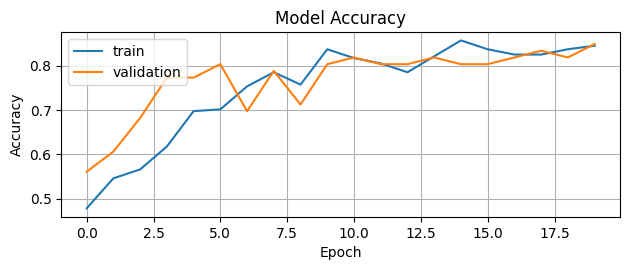

In [21]:
plotting_accuracy(history_2)

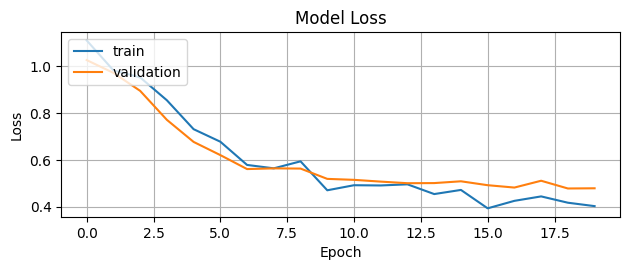

In [22]:
plotting_loss(history_2)

In [23]:
evaluation_metrics(model_2)

3/3 [==============================] - 0s 33ms/step
Confusion Matrix
[[11  9  6]
 [ 7  9  4]
 [ 5  7  8]]
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.42      0.45        26
           1       0.36      0.45      0.40        20
           2       0.44      0.40      0.42        20

    accuracy                           0.42        66
   macro avg       0.43      0.42      0.42        66
weighted avg       0.43      0.42      0.43        66



In [ ]:
history_3 = model_3.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

In [ ]:
plotting_accuracy(history_3)

In [ ]:
plotting_loss(history_3)

In [ ]:
evaluation_metrics(model_3)